*This script will extract delirium phenotypes from ukb data, and create a table with gwas covariates + phenotypes*

**Add pre-installed package path & load packages:**

In [1]:
.libPaths(c(.libPaths(), "/exports/eddie3_apps_local/apps/SL7/R/4.3.0/lib64/R/library"))

In [2]:
library("dplyr", warn.conflicts = F)
library("stringr", warn.conflicts = F)
library("data.table", warn.conflicts = F) 
library("vroom", warn.conflicts = F)
library("ggplot2", warn.conflicts = F)
library("tidyr", warn.conflicts = F)

**Change working directory:**

In [3]:
wd = "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/Download#675074/"
setwd(wd)
getwd()

[1] "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/Download#675074"

**Load data:**

In [4]:
file <- "ukb675074_vr.csv" # .csv with selected fields
a    <- fread(file)
a    <- as_tibble(a)

**Load extra data (assessment centre; field 54*):**

In [5]:
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/extra_data/f54.ass.centre.csv"
b    <- fread(file)
b    <- b %>% select(eid, `54-0.0`)  # select only assessment centre from first visit 
a    <- inner_join(a, b, by = "eid") # merge with main dataset based on "eid"

**Load extra data (dementia outcomes):**

In [6]:
file <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/extra_data/dementia_outcomes.csv"
c    <- fread(file)
# select only "Date of all cause dementia report"; field 42018
c    <- c %>% select(eid, `42018-0.0`) %>% filter(`42018-0.0` != "1900-01-01") 
a    <-left_join(a, c, by = "eid") # merge with main dataset based on "eid"

**Exclude latest withdrawls eids:**

In [7]:
w_eids <- fread("/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/ukb_data/ukb44986/withdraw44986_131_20231013.txt")
w_eids <- w_eids$V1

In [8]:
a <- a %>% filter(!(eid %in% w_eids))

**Table preview:**

In [9]:
dim(a)
head(a)

[1] 502356    996

eid,31-0.0,34-0.0,52-0.0,53-0.0,53-1.0,53-2.0,53-3.0,21003-0.0,21003-1.0,⋯,41283-0.10,41283-0.11,41283-0.12,41283-0.13,41283-0.14,41283-0.15,130846-0.0,130847-0.0,54-0.0,42018-0.0
<int>,<int>,<int>,<int>,<IDate>,<IDate>,<IDate>,<IDate>,<int>,<int>,⋯,<IDate>,<IDate>,<IDate>,<IDate>,<IDate>,<IDate>,<IDate>,<int>,<int>,<IDate>
1000015,1,1940,11,2008-04-23,NA,NA,NA,67,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,11010,NA
1000027,1,1946,9,2008-07-23,NA,NA,NA,61,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,11009,NA
1000039,0,1953,10,2008-12-06,NA,NA,NA,55,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,11007,NA
1000040,1,1966,3,2008-09-02,2012-09-12,2015-04-22,2021-02-03,42,46,⋯,NA,NA,NA,NA,NA,NA,NA,NA,11008,NA
1000053,0,1968,2,2009-02-28,NA,NA,NA,41,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,11016,NA
1000064,0,1964,3,2010-09-10,NA,NA,NA,46,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,11023,NA


**Get eids for people with delirium:** <br>
- **ICD10 diagnoses: code *F05* present in 41270-0.* columns** <br>
- **ICD9 diagnoses: code *2930* present in 41271-0.* columns** <br>
- **Primary cause of death (ICD10): code *F05* present in 40001* columns** <br>
- **Secondary cause of death (ICD10): code *F05* present in 40002* columns** <br>


In [10]:
# icd10 diagnoses 
del_eids_icd10 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F05"))) %>% pull(eid)
print(paste0("icd10 delirium dignoses: n=", length(del_eids_icd10)))
# icd9 diagnoses
del_eids_icd9 <- a %>% filter(if_any(starts_with("41271-0"), ~ str_detect(.,"2930"))) %>% pull(eid)
print(paste0("icd9 delirium dignoses: n=", length(del_eids_icd9)))
# primary cause of death 
del_eids_d1 <- a %>% filter(if_any(starts_with("40001"), ~ str_detect(.,"F05"))) %>% pull(eid)
print(paste0("deaths with delirium as primary cause: n=", length(del_eids_d1)))
# secondary cause of death 
del_eids_d2 <- a %>% filter(if_any(starts_with("40002"), ~ str_detect(.,"F05"))) %>% pull(eid)
print(paste0("deaths with delirium as secondary cause: n=", length(del_eids_d2)))


[1] "icd10 delirium dignoses: n=9114"
[1] "icd9 delirium dignoses: n=9"
[1] "deaths with delirium as primary cause: n=4"
[1] "deaths with delirium as secondary cause: n=51"


In [11]:
del_eidsA <- c(del_eids_icd10, del_eids_icd9, del_eids_d1, del_eids_d2) %>% unique 
print(paste0("at least one delirium occurance: n=", length(del_eidsA)))

[1] "at least one delirium occurance: n=9131"


**Eids for delirium subcodes:**

In [10]:
# delirium not superimposed on dementia - F05.0
eids_F050 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F050"))) %>% pull(eid)
print(paste0("Delirium not superimposed on dementia, so described: n=", length(eids_F050)))
# delirium superimposed on dementia - F05.1
eids_F051 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F051"))) %>% pull(eid)
print(paste0("Delirium superimposed on dementia: n=", length(eids_F051)))
# other delirium - F05.8
eids_F058 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F058"))) %>% pull(eid)
print(paste0("Other delirium: n=", length(eids_F058)))
# unspecified delirium - F05.9
eids_F059 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F059"))) %>% pull(eid)
print(paste0("Delirium, unspecified: n=", length(eids_F059)))
print("")

# Alcohol withdrawal state with delirium - F10.4 
eids_F104 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F104"))) %>% pull(eid)
print(paste0("Alcohol withdrawal state with delirium: n=", length(eids_F104)))
# Opioid withdrawal state with delirium - F11.4 
eids_F114 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F114"))) %>% pull(eid)
print(paste0("Opioid withdrawal state with delirium: n=", length(eids_F114)))
# Sedatives or hypnotics withdrawal state with delirium - F13.4 
eids_F134 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F134"))) %>% pull(eid)
print(paste0("Sedatives or hypnotics withdrawal state with delirium: n=", length(eids_F134)))
# Tobacco withdrawal state with delirium - F17.4 
eids_F174 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F174"))) %>% pull(eid)
print(paste0("Tobacco withdrawal state with delirium: n=", length(eids_F174)))
# Multiple drug use and use of other psychoactive substances withdrawal state with delirium - F19.4 
eids_F194 <- a %>% filter(if_any(starts_with("41270-0"), ~ str_detect(.,"F194"))) %>% pull(eid)
print(paste0("Multiple drug use and use of other psychoactive substances, withdrawal state with delirium: n=", length(eids_F194)))




[1] "Delirium not superimposed on dementia, so described: n=1413"
[1] "Delirium superimposed on dementia: n=1758"
[1] "Other delirium: n=1184"
[1] "Delirium, unspecified: n=6064"
[1] ""
[1] "Alcohol withdrawal state with delirium: n=221"
[1] "Opioid withdrawal state with delirium: n=1"
[1] "Sedatives or hypnotics withdrawal state with delirium: n=1"
[1] "Tobacco withdrawal state with delirium: n=6"
[1] "Multiple drug use and use of other psychoactive substances, withdrawal state with delirium: n=1"


Export subcodes eids:

In [12]:
#write.table(eids_F051, file="/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/pheno_covar_files/eids_F051", row.names=F, col.names=F)
#write.table(eids_F050, file="/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/pheno_covar_files/eids_F050", row.names=F, col.names=F)

**Althernatively: based on the eids with valid "date of F05 first reported":**


In [12]:
del_eids <- a %>% filter(!(is.na(`130846-0.0`))) %>% pull(eid)
print(paste0("at least one delirium occurance: n=", length(del_eids)))

[1] "at least one delirium occurance: n=9150"


**Get eids for dead people: have a non NA age at death (cols 40007*):**

In [13]:
dead_eids <-
    a %>% 
    filter(if_any(starts_with("40007"), ~ !is.na(.))) %>%
    pull(eid)
print(paste0("Individuals who have died: n=", length(dead_eids))) 

# columns 40007-0.0 and 40007-1.0 are the same, use only 40007-0.0
all(a$`40007-0.0` == a$`40007-1.0`, na.rm = T)

[1] "Individuals who have died: n=44500"


[1] TRUE

**Rename & create columns:**

In [18]:
#names(a)

In [14]:
a1 <- 
a %>% 
    # remale useful columns
    rename(
        "sex" = "31-0.0",
        "YOB" = "34-0.0",
        "MOB" = "52-0.0",
        "DOA_0" = "53-0.0", # date of attending assessment centre
        "DOA_1" = "53-1.0", 
        "DOA_2" = "53-2.0",
        "DOA_3" = "53-3.0",
        "AAA"   = "21003-0.0", # Age when attended assessment centre
        "ass_centre" = "54-0.0",
        "batch" = "22000-0.0",
        "g_sex" = "22001-0.0",
        "het_miss_outlier" = "22027-0.0",
        "sex_chr_aneuploidy" = "22019-0.0",
        "g_kinship" = "22021-0.0",
        "g_ethnicity" = "22006-0.0",
        "age_death" = "40007-0.0",
        "delirium_date"= "130846-0.0",
        "delirium_source" = "130847-0.0",
        "provider_0" = "40022-0.0", # provider of inpatient data 
        "provider_1" = "40022-0.1",
        "provider_2" = "40022-0.2",
        "dementia_date" = "42018-0.0"
        
    ) %>%
    rename_with(~gsub("22009-0.", "PC", x=.), .cols = starts_with("22009-0")) %>%
    # replace empty values with NAs in data provider columns
    mutate(across(starts_with("provider"), ~ na_if(.,""))) %>%
    # replace empty values with NAs in icd10 diagnoses codes columns
    mutate(across(starts_with("41270-0"), ~ na_if(.,""))) %>% 
    # make variable: has the individual any icd10 diagnosis? 
    mutate(hasICD10 = ifelse(!is.na(`41270-0.0`),1,0)) %>% 
    # make an IDate class column for approx. DOB. Day of birth is not accessible so set to 15th
    mutate(approx_dob = as.IDate(ISOdate(year=YOB, month=MOB, day=15))) %>%
    ## make a dummy age at first assessment variable based on approx. dob and date of assessment
    mutate(approx_AAA = round(as.numeric(difftime(DOA_0, approx_dob, units="days")) / 365.25, digits=2)) %>%
    # make isdead variable: dead (1) or alive (0)
    mutate(isdead = ifelse(eid %in% dead_eids, 1, 0)) %>%
    # make outcome variable: delirium case (1) or control (0) 
    mutate(delirium = ifelse(eid %in% del_eids, 1, 0)) %>% 
    # extract selected columns
    select(eid, YOB, MOB, approx_dob, starts_with("DOA"), AAA, approx_AAA, ass_centre, batch, sex, g_sex, het_miss_outlier, sex_chr_aneuploidy, g_ethnicity, g_kinship, 
           paste0("PC", seq(1,20)), starts_with("provider"), hasICD10, isdead, age_death, dementia_date, delirium_source, delirium_date, delirium, 
           starts_with("41270-0"), starts_with("41280-0"))


**Make dementia incident / prevalent variable:**

In [15]:
# dementia_incident: 
# -1 = dementia before delirium (prevalent); 
# 0 = same date as delirium; 
# 1 = after delirium (incident)
a1 <-
a1 %>% mutate(dementia_incident = case_when( (as.IDate(delirium_date) < as.IDate(dementia_date))  ~ 1,
                                             (as.IDate(delirium_date) > as.IDate(dementia_date)) ~ -1,
                                             (as.IDate(delirium_date) == as.IDate(dementia_date)) ~ 0,
                                             TRUE ~ NA)) %>% 
   mutate(dementia_status = ifelse(!is.na(dementia_date),1,0))

In [16]:
# exclcude icd codes diagnoses and dates columns
a2 <-
a1 %>%
    # extract selected columns
    select(eid, YOB, MOB, approx_dob, starts_with("DOA"), AAA, approx_AAA, ass_centre, batch, sex, g_sex, het_miss_outlier, sex_chr_aneuploidy, g_ethnicity, g_kinship, 
           paste0("PC", seq(1,20)), starts_with("provider"), hasICD10, isdead, age_death, dementia_status, dementia_incident, delirium_source, delirium_date, delirium)
           #starts_with("41270-0"), starts_with("41262-0"))


**Make "age" variables:** <br>
- for cases: *date of diagnosis - dob* <br>
- for dead controls: *age at death* <br>
- for alive controls: *date of cencoring - dob* <br>

\* cencoring dates are different depending on provider, see these: <br>
https://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=40022 (providers) <br>
https://biobank.ndph.ox.ac.uk/ukb/exinfo.cgi?src=Data_providers_and_dates (censoring dates) <br>

In [17]:
# create censoring dates (as of: 15.10.23)

#  HES: 31 October 2022
#  SMR: 31 August 2022
# PEDW: 31 May 2022
# no data: 31 October 2022 (assumed healthy?)

a2 <-
a2 %>% 
    mutate(censoring_date = case_when( (provider_0 == "HES")  ~ as.IDate(ISOdate(2022,10,31)),
                                       (provider_0 == "SMR" | provider_1 == "SMR" | provider_2 == "SMR")    ~ as.IDate(ISOdate(2022,08,31)),
                                       (provider_0 == "PEDW" | provider_1 == "PEDW" | provider_2 == "PEDW") ~ as.IDate(ISOdate(2022,05,31)),
                                       TRUE ~ as.IDate(ISOdate(2022,10,31))))


In [18]:
# create age variable
a2 <-
a2 %>% 
    mutate(age = case_when((delirium == 1) ~ round(as.numeric(difftime(delirium_date, approx_dob, units="days")) / 365.25, digits=1), # cases
                           (delirium == 0 & isdead == 0) ~ round(as.numeric(difftime(censoring_date, approx_dob, units="days")) / 365.25, digits=1), # alive control
                           (delirium == 0 & isdead == 1) ~ round(as.numeric(age_death), digits = 1))) # dead controls 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23.90   71.60   75.50   74.38   78.80   85.50 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.30   63.90   71.30   70.21   76.60   88.60 

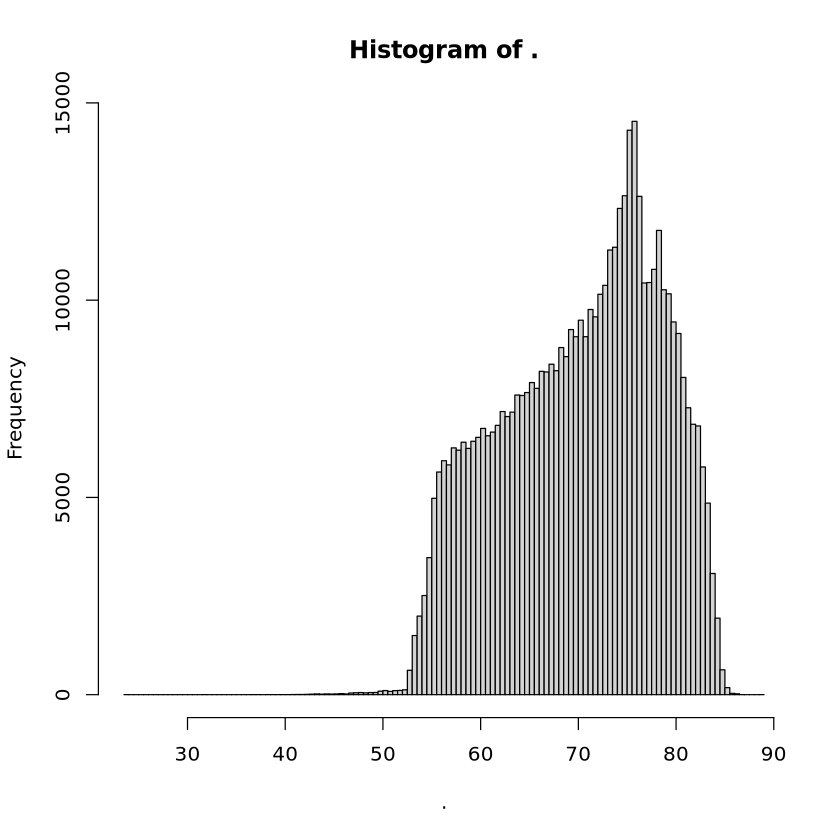

In [19]:
a2 %>% filter(delirium == 1) %>% pull(age) %>% summary()
a2 %>% filter(delirium == 0) %>% pull(age) %>%summary()

a2 %>% pull(age) %>% hist(.,breaks=100)

In [20]:
# half of people with delirium have died!
a2 %>% group_by(delirium, isdead) %>% summarise(n = n(), )

`summarise()` has grouped output by 'delirium'. You can override using the `.groups` argument.


delirium,isdead,n
<dbl>,<dbl>,<int>
0,0,453226
0,1,39980
1,0,4630
1,1,4520


In [27]:
# eids used in gwas
#ii <- fread("../../../vasilis/PHD/ukb.delirium.gwas/regenie_files/extraction_files/qc_pass_called.id")
#ii <- ii$V1 
#head(ii)

[1] 1000015 1000027 1000039 1000040 1000053 1000064

In [21]:
# make incident (1) / prevalent (0) cases variable
#a3 %
a2 <-
a2 %>% mutate(incident = case_when( (delirium == 1 & age > AAA) ~ 1,
                                    (delirium == 1 & age < AAA) ~ 0,
                                    (delirium == 1) ~ -999,
                                    TRUE ~ NA))

a2 %>% group_by(incident) %>% summarise(n = n())


incident,n
<dbl>,<int>
0,74
1,9076
NA,493206


In [22]:
head(a2)
dim(a2)

eid,YOB,MOB,approx_dob,DOA_0,DOA_1,DOA_2,DOA_3,AAA,approx_AAA,⋯,isdead,age_death,dementia_status,dementia_incident,delirium_source,delirium_date,delirium,censoring_date,age,incident
<int>,<int>,<int>,<IDate>,<IDate>,<IDate>,<IDate>,<IDate>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<IDate>,<dbl>,<IDate>,<dbl>,<dbl>
1000015,1940,11,1940-11-15,2008-04-23,NA,NA,NA,67,67.44,⋯,0,NA,0,NA,NA,NA,0,2022-10-31,82.0,NA
1000027,1946,9,1946-09-15,2008-07-23,NA,NA,NA,61,61.85,⋯,0,NA,0,NA,NA,NA,0,2022-10-31,76.1,NA
1000039,1953,10,1953-10-15,2008-12-06,NA,NA,NA,55,55.14,⋯,0,NA,0,NA,NA,NA,0,2022-10-31,69.0,NA
1000040,1966,3,1966-03-15,2008-09-02,2012-09-12,2015-04-22,2021-02-03,42,42.47,⋯,0,NA,0,NA,NA,NA,0,2022-10-31,56.6,NA
1000053,1968,2,1968-02-15,2009-02-28,NA,NA,NA,41,41.04,⋯,0,NA,0,NA,NA,NA,0,2022-10-31,54.7,NA
1000064,1964,3,1964-03-15,2010-09-10,NA,NA,NA,46,46.49,⋯,0,NA,0,NA,NA,NA,0,2022-10-31,58.6,NA


[1] 502356     52

**Summary characteristics table:**

For all participants:

In [23]:
# age at last data freeze (2022): 
a2 %>% 
    filter(isdead != 1) %>% 
    mutate(age_at_cens = round(as.numeric(difftime(censoring_date, approx_dob, units="days")) / 365.25, digits=1)) %>% 
    pull(age_at_cens) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  51.00   63.70   71.30   70.26   76.80   88.60 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


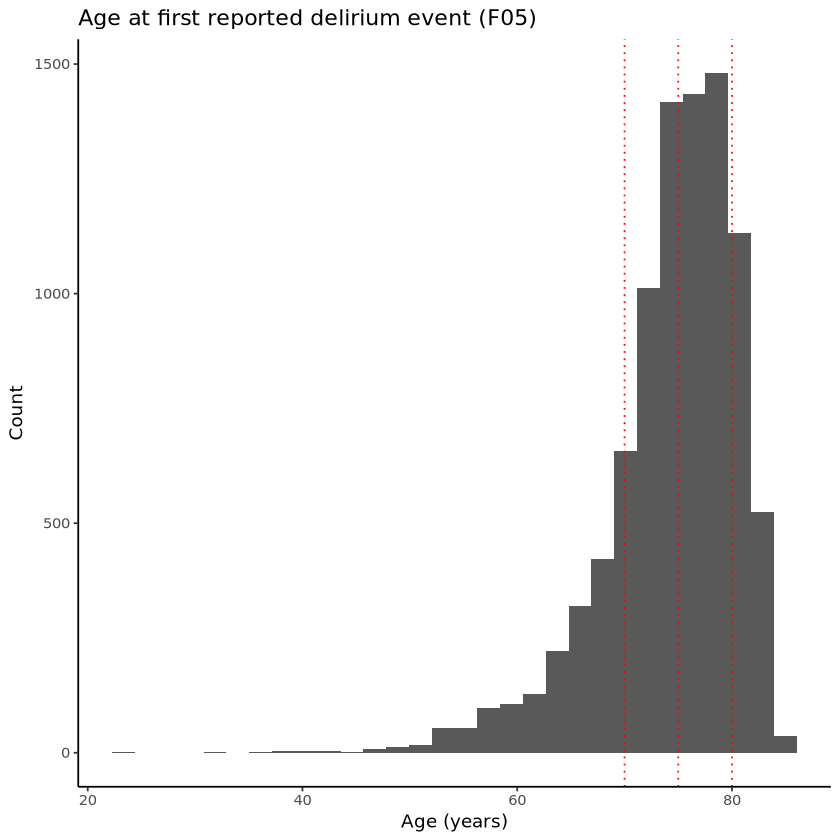

In [26]:
# age at 1st reported delirium
ggplot(data = a2[a2$delirium==1,], aes(age)) + 
geom_histogram(na.rm = T) + 
theme_bw() +
theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) +
geom_vline(xintercept = c(70,75,80), color="red", linetype="dotted") + 
labs(title="Age at first reported delirium event (F05)",
     x ="Age (years)", 
     y = "Count") 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


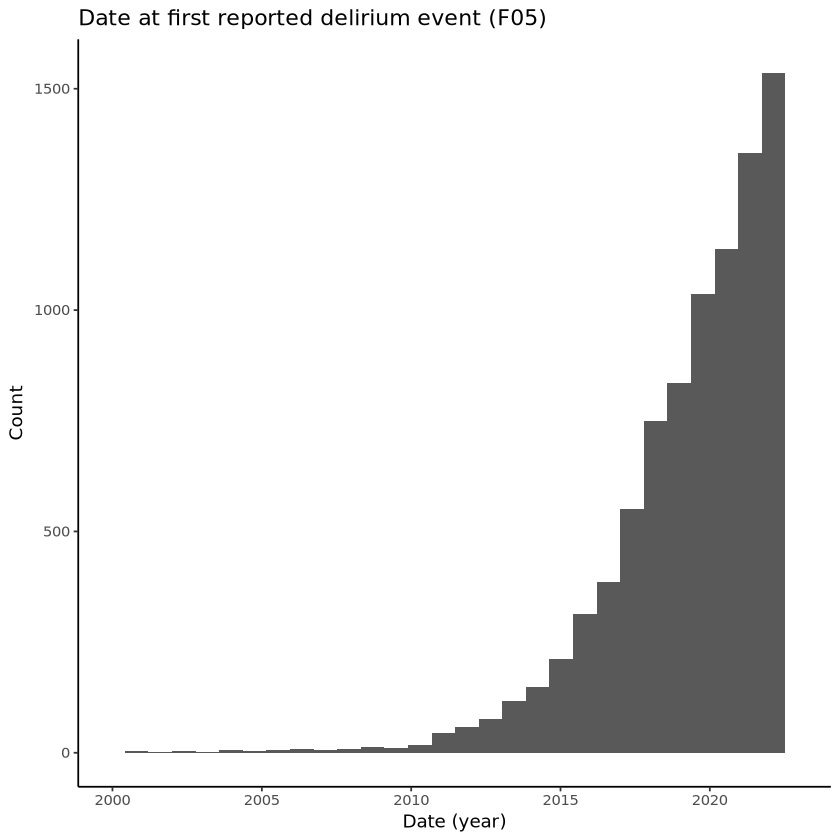

In [27]:
# date at 1st reported delirium
ggplot(data = a, aes(`130846-0.0`)) + 
geom_histogram(na.rm = T) + 
theme_bw() +
theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) +
labs(title="Date at first reported delirium event (F05)",
     x ="Date (year)", 
     y = "Count") +
xlim(as.IDate(c("2000-01-01", "2022-11-28")))


In [28]:
#sex: 0=female; 1=male
a2 %>% group_by(isdead) %>% summarise(n = n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(sex) %>% summarise(n = n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(sex) %>% summarise(n = n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(g_ethnicity) %>% summarise(n = n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(dementia_status) %>% summarise(n = n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(delirium) %>% summarise(n = n()) %>% mutate(freq = n/sum(n))


isdead,n,freq
<dbl>,<int>,<dbl>
0,457856,0.9114174
1,44500,0.0885826


sex,n,freq
<int>,<int>,<dbl>
0,273294,0.5440246
1,229062,0.4559754


sex,n,freq
<int>,<int>,<dbl>
0,273294,0.5440246
1,229062,0.4559754


g_ethnicity,n,freq
<int>,<int>,<dbl>
1,409511,0.8151809
NA,92845,0.1848191


dementia_status,n,freq
<dbl>,<int>,<dbl>
0,492309,0.98000024
1,10047,0.01999976


delirium,n,freq
<dbl>,<int>,<dbl>
0,493206,0.98178583
1,9150,0.01821417


Mortality after delirium:

In [29]:
# survival (in days) after 1st delrium
del2death_days <-
    a2 %>% filter(delirium==1 & isdead==1) %>% 
    mutate(del2death_days = (age_death - age)*365.25) %>% select(age,age_death,del2death_days) %>% 
    pull(del2death_days) 

By delirium status:

In [63]:
#sex: 0=female; 1=male
a2 %>% group_by(delirium, dementia_incident) %>% summarise(n=n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(delirium, dementia_status) %>% summarise(n=n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(delirium, g_ethnicity) %>% summarise(n=n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(delirium, isdead) %>% summarise(n=n()) %>% mutate(freq = n/sum(n))
a2 %>% group_by(delirium) %>% summarise (mean = mean(AAA), sd = sd(AAA))
a2 %>% group_by(delirium,sex) %>% summarise (n=n()) %>% mutate(freq = n/sum(n))


`summarise()` has grouped output by 'delirium'. You can override using the
`.groups` argument.


delirium,dementia_incident,n,freq
<dbl>,<dbl>,<int>,<dbl>
0,NA,493206,1.00000000
1,-1,1368,0.14950820
1,0,903,0.09868852
1,1,972,0.10622951
1,NA,5907,0.64557377


`summarise()` has grouped output by 'delirium'. You can override using the
`.groups` argument.


delirium,dementia_status,n,freq
<dbl>,<dbl>,<int>,<dbl>
0,0,486402,0.98620455
0,1,6804,0.01379545
1,0,5907,0.64557377
1,1,3243,0.35442623


`summarise()` has grouped output by 'delirium'. You can override using the
`.groups` argument.


delirium,g_ethnicity,n,freq
<dbl>,<int>,<int>,<dbl>
0,1,401940,0.8149536
0,NA,91266,0.1850464
1,1,7571,0.8274317
1,NA,1579,0.1725683


`summarise()` has grouped output by 'delirium'. You can override using the
`.groups` argument.


delirium,isdead,n,freq
<dbl>,<dbl>,<int>,<dbl>
0,0,453226,0.91893854
0,1,39980,0.08106146
1,0,4630,0.50601093
1,1,4520,0.49398907


delirium,mean,sd
<dbl>,<dbl>,<dbl>
0,56.40253,8.08190
1,63.39989,5.37473


`summarise()` has grouped output by 'delirium'. You can override using the
`.groups` argument.


delirium,sex,n,freq
<dbl>,<int>,<int>,<dbl>
0,0,269349,0.5461187
0,1,223857,0.4538813
1,0,3945,0.4311475
1,1,5205,0.5688525


In [60]:
a2 %>% group_by(hasICD10) %>% summarise(n=n())

hasICD10,n
<dbl>,<int>
0,55361
1,446995


**Filter data based on:**
- no sex missmatch 
- white british ancestry 
- no heterozygosiry or missingness outlier
- no \>\=10 3rd degree relatives in dataset
- no sex chromosome aneuploidy


In [29]:
a3 <-
a2 %>% 
    filter(sex == g_sex, 
           is.na(het_miss_outlier), 
           g_ethnicity == 1,
           g_kinship != 10,
           is.na(sex_chr_aneuploidy)
           )
print(paste0("n=", dim(a3)[1], " white british individuals remaining"))
print(table(a3$delirium)) # 7523 delirium cases

[1] "n=407909 white british individuals remaining"

     0      1 
400386   7523 


In [30]:
x1 <- a2 %>% filter(age > 80 & delirium ==1) %>% nrow
x2 <- a2 %>% filter(age > 80 ) %>% nrow
x1 / x2
x1
x2

[1] 0.0264834

[1] 1447

[1] 54638

In [58]:
#ggplot(data = a, aes(`130846-0.0`)) + geom_histogram(na.rm = T)
## max date across multiple columns!
#a %>% summarise(across(starts_with("41262"), ~ max(., na.rm = TRUE)))

In [31]:
names(a3)

[1] "eid"                "YOB"                "MOB"                "approx_dob"         "DOA_0"              "DOA_1"              "DOA_2"              "DOA_3"              "AAA"               
[10] "approx_AAA"         "ass_centre"         "batch"              "sex"                "g_sex"              "het_miss_outlier"   "sex_chr_aneuploidy" "g_ethnicity"        "g_kinship"         
[19] "PC1"                "PC2"                "PC3"                "PC4"                "PC5"                "PC6"                "PC7"                "PC8"                "PC9"               
[28] "PC10"               "PC11"               "PC12"               "PC13"               "PC14"               "PC15"               "PC16"               "PC17"               "PC18"              
[37] "PC19"               "PC20"               "provider_0"         "provider_1"         "provider_2"         "hasICD10"           "isdead"             "age_death"          "dementia_status"   
[46] "dementia_incident"  "delirium_source"    "delirium_date"      "delirium"           "censoring_date"     "age"                "incident"

**Dementia stats:**

In [33]:
a3 %>% 
    group_by(delirium) %>% 
    summarise(n_del =n(), 
              `dementia (%)` = round((sum(dementia_status==1)/n())*100,2),
              `dementia_prev (%)` = round((sum(dementia_incident==0 | dementia_incident==-1, na.rm = T)/n())*100,2),
              `dementia_inc (%)` = round((sum(dementia_incident==1, na.rm = T)/n())*100,2)              
              )
 

delirium,n_del,dementia (%),dementia_prev (%),dementia_inc (%)
<dbl>,<int>,<dbl>,<dbl>,<dbl>
0,400386,1.40,0.00,0.00
1,7523,35.56,24.95,10.61


**Test significant covariates:**

In [105]:
#formula <- paste("delirium ~ age + sex + batch + ass_centre + ", paste0("PC", 1:20, collapse="+"))
#glm(formula = formula, data = a3, family = "binomial") %>% summary
## assessment centre not significant (drop)
formula <- paste("delirium ~ age + sex + batch + ", paste0("PC", 1:20, collapse="+"))
glm(formula = formula, data = a3, family = "binomial") %>% summary


Call:
glm(formula = formula, family = "binomial", data = a3)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.6023031  0.1622577 -59.179  < 2e-16 ***
age          0.0734504  0.0017422  42.160  < 2e-16 ***
sex          0.4416889  0.0235780  18.733  < 2e-16 ***
batch       -0.0015963  0.0003804  -4.196 2.71e-05 ***
PC1         -0.0068470  0.0076788  -0.892  0.37257    
PC2          0.0113811  0.0079500   1.432  0.15226    
PC3          0.0147386  0.0077017   1.914  0.05566 .  
PC4          0.0124482  0.0059158   2.104  0.03536 *  
PC5          0.0026568  0.0025186   1.055  0.29148    
PC6         -0.0035073  0.0073767  -0.475  0.63446    
PC7          0.0014953  0.0066620   0.224  0.82240    
PC8         -0.0010222  0.0066852  -0.153  0.87847    
PC9          0.0157721  0.0028169   5.599 2.15e-08 ***
PC10        -0.0185299  0.0063806  -2.904  0.00368 ** 
PC11         0.0117684  0.0047234   2.492  0.01272 *  
PC12         0.0033138  0.0063544   0.521  

In [22]:
head(a3)

eid,YOB,MOB,approx_dob,DOA_0,DOA_1,DOA_2,DOA_3,AAA,ass_centre,⋯,provider_1,provider_2,isdead,age_death,delirium_source,delirium_date,delirium,censoring_date,age,incident
<int>,<int>,<int>,<IDate>,<IDate>,<IDate>,<IDate>,<IDate>,<int>,<int>,⋯,<chr>,<chr>,<dbl>,<dbl>,<int>,<IDate>,<dbl>,<IDate>,<dbl>,<dbl>
1000015,1940,11,1940-11-15,2008-04-23,NA,NA,NA,67,11010,⋯,NA,NA,0,NA,NA,NA,0,2022-10-31,82.0,NA
1000027,1946,9,1946-09-15,2008-07-23,NA,NA,NA,61,11009,⋯,NA,NA,0,NA,NA,NA,0,2022-10-31,76.1,NA
1000039,1953,10,1953-10-15,2008-12-06,NA,NA,NA,55,11007,⋯,NA,NA,0,NA,NA,NA,0,2022-10-31,69.0,NA
1000040,1966,3,1966-03-15,2008-09-02,2012-09-12,2015-04-22,2021-02-03,42,11008,⋯,NA,NA,0,NA,NA,NA,0,2022-10-31,56.6,NA
1000053,1968,2,1968-02-15,2009-02-28,NA,NA,NA,41,11016,⋯,NA,NA,0,NA,NA,NA,0,2022-10-31,54.7,NA
1000064,1964,3,1964-03-15,2010-09-10,NA,NA,NA,46,11023,⋯,NA,NA,0,NA,NA,NA,0,2022-10-31,58.6,NA


In [ ]:
a3 %>% 
    mutate(del2death_time = case_when( (delirium == 1 & isdead == 1) ~ 1,)



**Export .txt file with GWAS covariates and phenotype for regenie** <br>
Space separated with header: FID IID C1 C2 C3 P1 <br> see:https://rgcgithub.github.io/regenie/options/#covariate-file-format 

In [24]:
a4 <- a3 %>% rename("IID" = "eid") %>% mutate(FID = IID) %>% select(FID, IID, sex, age, batch, starts_with("PC"), delirium) 
head(a4)
dim(a4)

FID,IID,sex,age,batch,PC1,PC2,PC3,PC4,PC5,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,delirium
<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000015,1000015,1,82.0,50,-11.09950,2.14877,-0.949851,1.1805100,-4.60573,⋯,1.574560,-2.916850,2.175070,1.907590,4.519030,-2.286550,3.96858,-0.788353,1.93067,0
1000027,1000027,1,76.1,2,-12.97330,3.09785,-3.105400,1.3686900,3.41731,⋯,5.039110,-2.353550,-1.793530,0.706703,-0.999209,-2.607720,1.20282,-1.513040,1.11784,0
1000039,1000039,0,69.0,29,-12.66950,3.55335,1.488820,-0.0348311,-1.25356,⋯,2.909280,4.193440,0.672521,1.359980,-1.831130,0.799422,-1.41593,2.958720,-1.90233,0
1000040,1000040,1,56.6,-5,-15.38280,3.44060,-2.842940,2.6655800,-5.93685,⋯,-2.669600,-0.808776,4.186370,-3.066330,-3.256040,0.738720,-8.48556,-1.488910,1.29605,0
1000053,1000053,0,54.7,19,-12.19880,2.87228,1.880270,0.8088970,2.96457,⋯,0.694553,-0.654478,-0.361432,-1.871140,-6.937880,0.730852,7.18108,3.132090,-1.14368,0
1000064,1000064,0,58.6,49,-9.34817,2.55701,-0.396884,2.8227800,4.40571,⋯,1.586540,2.108090,2.906990,-2.422250,-0.748403,1.381250,3.64285,0.389771,-7.62980,0


[1] 407909     26

In [70]:
outfile <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/regenie_files/ukb_wb_del_cov_phe.txt"
write.table(a4, file=outfile, quote=F, sep=" ", row.names=F, col.names=T)

**Export .txt file with useful dates:** <br>


In [33]:
names(a3)

[1] "eid"                "YOB"                "MOB"               
 [4] "approx_dob"         "DOA_0"              "DOA_1"             
 [7] "DOA_2"              "DOA_3"              "AAA"               
[10] "approx_AAA"         "ass_centre"         "batch"             
[13] "sex"                "g_sex"              "het_miss_outlier"  
[16] "sex_chr_aneuploidy" "g_ethnicity"        "g_kinship"         
[19] "PC1"                "PC2"                "PC3"               
[22] "PC4"                "PC5"                "PC6"               
[25] "PC7"                "PC8"                "PC9"               
[28] "PC10"               "PC11"               "PC12"              
[31] "PC13"               "PC14"               "PC15"              
[34] "PC16"               "PC17"               "PC18"              
[37] "PC19"               "PC20"               "provider_0"        
[40] "provider_1"         "provider_2"         "hasICD10"          
[43] "isdead"             "age_death"          "dementia_status"   
[46] "dementia_incident"  "delirium_source"    "delirium_date"     
[49] "delirium"           "censoring_date"     "age"               
[52] "incident"

In [34]:
a_prot <- a3 %>% 
    rename("IID" = "eid") %>% mutate(FID = IID) %>%
    select(FID, IID, sex, age, approx_dob, approx_AAA, age_death, delirium_date, censoring_date, delirium) 
head(a_prot)
dim(a_prot)
write.table(a_prot, file="/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/proteomics/Resource/pheno/delirium.phe", quote=F, sep=" ", row.names=F, col.names=T)

FID,IID,sex,age,approx_dob,approx_AAA,age_death,delirium_date,censoring_date,delirium
<int>,<int>,<int>,<dbl>,<IDate>,<dbl>,<dbl>,<IDate>,<IDate>,<dbl>
1000015,1000015,1,82.0,1940-11-15,67.44,NA,NA,2022-10-31,0
1000027,1000027,1,76.1,1946-09-15,61.85,NA,NA,2022-10-31,0
1000039,1000039,0,69.0,1953-10-15,55.14,NA,NA,2022-10-31,0
1000040,1000040,1,56.6,1966-03-15,42.47,NA,NA,2022-10-31,0
1000053,1000053,0,54.7,1968-02-15,41.04,NA,NA,2022-10-31,0
1000064,1000064,0,58.6,1964-03-15,46.49,NA,NA,2022-10-31,0


[1] 407909     10

**Export .txt file with delirium & dead phenotype**

In [17]:
a5 <- a3 %>% mutate(del2death = case_when( (delirium == 1 & isdead == 1) ~ 1,
                                      (delirium == 1 & isdead == 0) ~ 0,
                                      TRUE ~ NA)) 


In [21]:
a5 <- a5 %>% 
    rename("IID" = "eid") %>% 
    mutate(FID = IID) %>% 
    filter(!is.na(del2death)) %>%
    select(FID, IID, sex, age, batch, starts_with("PC"), del2death) 

In [25]:
outfile2 <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/pheno_covar_files/ukb_wb_del2death_cov_phe.txt"
write.table(a5, file=outfile2, quote=F, sep=" ", row.names=F, col.names=T)

**Export file used here**

In [32]:
outfile3 <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/pheno_covar_files/prelim_file.txt"
write.table(a3, file=outfile3, quote=F, sep=" ", row.names=F, col.names=T)

**Get dates of diagnoses**

In [13]:
#names(a1)
dim(a1)

[1] 502356    563

In [14]:
# extract tables with diag. codes and dates
a1_icd10 <- a1 %>% select(eid, starts_with("41270-0")) 
a1_dates <- a1 %>% select(eid, starts_with("41280-0"))


In [15]:
# empty output tibble
del_full <- tibble(eid = del_eids, del = character(length(del_eids)))

# use dataset a1
for (id in del_eids){
    #print(id)
    # per del_eid: temp named character vector with names: columns correspinding to full del code; values: full delirium code
    tt <- a1_icd10 %>%
        filter(eid==id) %>%
        select(where(~any( str_detect(.,"F05"),na.rm = T))) %>%
        unlist(use.names = T)
    # extract array number from 41270* column and make corresponding 41280* column 
    arrs       <- names(tt)%>% gsub(pattern = ".*\\.", replacement = "")
    dates_cols <- names(tt)%>% gsub(pattern = ".*\\.", replacement = "41280-0.")
    #print(dates_cols)
    #print(unname(tt))
    ## extract codes only
    temp_codes <- unname(tt)
    ## extract dates
    temp_dates <- a1_dates %>%
        filter(eid==id) %>%
        select(all_of(dates_cols)) %>%
        do.call("c",.)
    ## paste <code>:<date> for each del diagnosis
    temp_codes_dates1 <- paste0(temp_codes, ":", temp_dates)
    ## paste multiple diagnoses into one sring <codeA>:<dateA>_<codeB>:<dateB> per individual
    temp_codes_dates2 <- paste0(temp_codes_dates1, collapse = "_")
    ## append tibble with <codeA>:<dateA>_<codeB>:<dateB> per individual eid 
    #del_full[[as.character(id)]] = temp_codes_dates1
    del_full[del_full$eid == id, 'del'] <- temp_codes_dates2
}

del_full %>% head

eid,del
<int>,<chr>
1000346,F051:2022-06-27_F059:2021-02-22
1000493,F051:2022-05-27
1000820,F059:2010-11-24
1000843,F051:2020-09-28
1001307,F059:2020-04-12
1001641,F059:2019-04-06


In [68]:
# some eids are without info (del = ":"), this is beacuse del_eids also include delirium from other sources (e.g. death records)
del_full[del_full$del==":","del"] <- NA # replace with NA

In [77]:
del_full2 <-
del_full %>% 
    separate_wider_delim(cols = "del", names_sep=".", delim="_", too_few = "align_start") %>%
    separate_wider_delim(cols = names(.)[-1], names=c("code","date"), names_sep="_", delim=":", too_few = "align_start")


In [117]:
#del_full2 %>% filter(!is.na(del.3_code)) %>% head

In [116]:
# non-NA entries 
del_full2 %>% summarise(across(ends_with("code"), ~ sum(!is.na(.))))

del.1_code,del.2_code,del.3_code,del.4_code
<int>,<int>,<int>,<int>
9114,1163,130,12


In [173]:
# column with the number of delirium episodes
del_full3 <-
del_full2 %>% rowwise %>% 
    mutate(del_count = sum(!is.na(across(ends_with("code"))))) %>%
    ungroup %>%
    # convert to date format
    mutate(del.1_date = as.IDate(del.1_date)) %>%
    mutate(del.2_date = as.IDate(del.2_date)) %>%
    mutate(del.3_date = as.IDate(del.3_date)) %>%
    mutate(del.4_date = as.IDate(del.4_date)) 

In [174]:
# number of delirium episodes per individual
del_full3 %>% count(del_count) %>% t

del_count,0,1,2,3,4
n,36,7951,1033,118,12


In [175]:
dim(del_full3)
head(del_full3)

[1] 9150   10

eid,del.1_code,del.1_date,del.2_code,del.2_date,del.3_code,del.3_date,del.4_code,del.4_date,del_count
<int>,<chr>,<IDate>,<chr>,<IDate>,<chr>,<IDate>,<chr>,<IDate>,<int>
1000346,F051,2022-06-27,F059,2021-02-22,NA,NA,NA,NA,2
1000493,F051,2022-05-27,NA,NA,NA,NA,NA,NA,1
1000820,F059,2010-11-24,NA,NA,NA,NA,NA,NA,1
1000843,F051,2020-09-28,NA,NA,NA,NA,NA,NA,1
1001307,F059,2020-04-12,NA,NA,NA,NA,NA,NA,1
1001641,F059,2019-04-06,NA,NA,NA,NA,NA,NA,1


test if earliest date matches pre-computed

In [185]:
x <- left_join(x=del_full3, y=a1[,c("eid","delirium_date")], by="eid") %>%
    mutate(min_date = pmin(del.1_date, del.2_date, del.3_date, del.4_date, na.rm = T))

In [194]:
x %>% mutate(diff = as.numeric(difftime(min_date, delirium_date, units="days"))) %>%
    filter(diff !=0)

eid,del.1_code,del.1_date,del.2_code,del.2_date,del.3_code,del.3_date,del.4_code,del.4_date,del_count,delirium_date,min_date,diff
<int>,<chr>,<IDate>,<chr>,<IDate>,<chr>,<IDate>,<chr>,<IDate>,<int>,<IDate>,<IDate>,<dbl>
2271419,F058,2022-01-16,NA,NA,NA,NA,NA,NA,1,2014-08-27,2022-01-16,2699
2433971,F050,2016-06-15,F059,2016-12-18,NA,NA,NA,NA,2,2015-06-15,2016-06-15,366
3690906,F058,2021-04-27,NA,NA,NA,NA,NA,NA,1,2021-04-14,2021-04-27,13
4231015,F059,2022-09-05,NA,NA,NA,NA,NA,NA,1,2014-10-06,2022-09-05,2891
5397644,F059,2020-05-07,NA,NA,NA,NA,NA,NA,1,2016-02-04,2020-05-07,1554


In [179]:
?pmin

Write full table

In [151]:
del_full_outfile <- "/exports/cmvm/eddie/smgphs/groups/Quantgen/Users/vasilis/PHD/ukb.delirium.gwas/pheno_covar_files/ukb_all_del_full.txt"
write.table(del_full3, del_full_outfile, quote=F, sep=" ", col.names=T, row.names=F)